In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
%matplotlib inline

In [2]:
print(keras.__version__) 

2.6.0


In [3]:
print(tf. __version__) 

2.6.2


In [4]:
train_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

In [5]:
valid_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [6]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)
batch_size = 32

In [7]:
train_aug = ImageDataGenerator(
    rescale=1/255.0,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    #validation_split=0.2
)

train_data = train_aug.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_aug = ImageDataGenerator(
    rescale=1/255.0
)

valid_data = valid_aug.flow_from_directory(
    valid_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
mbnet_v2 = keras.applications.MobileNetV2(
    weights = "imagenet",
    include_top=False,
    input_shape=input_shape
)

#mbnet_v2.trainable = False

2022-04-24 15:51:05.975144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 15:51:06.123833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 15:51:06.125141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 15:51:06.127319: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
for layer in mbnet_v2.layers[:145]:
    layer.trainable = False

In [10]:
for i, layer in enumerate(mbnet_v2.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [11]:
inputs = keras.Input(shape=input_shape)

x = mbnet_v2(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.05)(x)

outputs = tf.keras.layers.Dense(len(list(train_data.class_indices.keys())), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                48678     
Total params: 2,306,662
Trainable params: 779,238
Non-trainable params: 1,527,424
_________________________________________________________________


In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [13]:
history = model.fit(
    train_data,
    epochs=65,
    steps_per_epoch=150,
    #callbacks=[early_stopping_cb],
    validation_data=valid_data
)

2022-04-24 15:51:11.794958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/65


2022-04-24 15:51:16.862691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


150/150 [==============================] - 218s 1s/step - loss: 0.9149 - accuracy: 0.7387 - val_loss: 6.4374 - val_accuracy: 0.3502
Epoch 2/65
150/150 [==============================] - 132s 879ms/step - loss: 0.4396 - accuracy: 0.8625 - val_loss: 8.0521 - val_accuracy: 0.3227
Epoch 3/65
150/150 [==============================] - 131s 874ms/step - loss: 0.3714 - accuracy: 0.8785 - val_loss: 4.8544 - val_accuracy: 0.4689
Epoch 4/65
150/150 [==============================] - 133s 892ms/step - loss: 0.3288 - accuracy: 0.8927 - val_loss: 7.9255 - val_accuracy: 0.3515
Epoch 5/65
150/150 [==============================] - 132s 879ms/step - loss: 0.3075 - accuracy: 0.8958 - val_loss: 10.1411 - val_accuracy: 0.2851
Epoch 6/65
150/150 [==============================] - 129s 859ms/step - loss: 0.2845 - accuracy: 0.9079 - val_loss: 6.9104 - val_accuracy: 0.4285
Epoch 7/65
150/150 [==============================] - 128s 853ms/step - loss: 0.2546 - accuracy: 0.9160 - val_loss: 6.6727 - val_accuracy

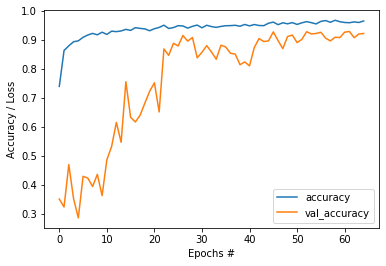

In [14]:
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
#plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    #plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [15]:
model.save("plant.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
loaded_model = tf. keras. models. load_model("./plant.h5")
loaded_model.evaluate(valid_data)

550/550 [==============================] - 56s 101ms/step - loss: 0.3489 - accuracy: 0.9212


[0.34885257482528687, 0.921238362789154]

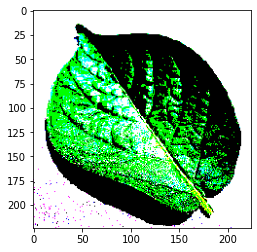

In [17]:
from tensorflow.keras.applications.resnet50 import preprocess_input
img_path = "../input/new-plant-diseases-dataset/test/test/PotatoHealthy1.JPG"
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img_batch = np.expand_dims(img, axis=0)
img_preprocessed = preprocess_input(img_batch)
plt.imshow(img)

In [18]:
predicted_class = np.argmax(model.predict(img_preprocessed))
print(predicted_class)

4


In [19]:
import json
from IPython.display import FileLink
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)
FileLink("categories.json")

/kaggle/working/categories.json